# MPPI (Model Predictive Path-Integral) Control

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from matplotlib import patches
from matplotlib.animation import ArtistAnimation
from IPython import display

## Control Target : CartPole

<img src="../media/cartpole.png" width="500px" />

In [2]:
class CartPole():
    def __init__(
            self,
            mass_of_cart: float = 1.0,
            mass_of_pole: float = 0.01,
            length_of_pole: float = 2.0,
            max_force_abs: float = 100.0,
            delta_t: float = 0.02,
            visualize: bool = True,
        ) -> None:
        """initialize cartpole environment
        state variables:
            x: horizontal position of the cart
            theta: angle of the pole (positive in the counter-clockwise direction)
            x_dot: horizontal velocity of the cart
            theta_dot: angular velocity of the pole
        control input:
            force: force applied to the cart (positive in the right direction)
        Note: dynamics of the cartpole is given by OpenAI gym implementation; https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
        """
        # physical parameters
        self.g = 9.81
        self.mass_of_cart = mass_of_cart
        self.mass_of_pole = mass_of_pole
        self.length_of_pole = length_of_pole
        self.max_force_abs = max_force_abs
        self.delta_t = delta_t

        # visualization settings
        self.cart_w = 1.8
        self.cart_h = 1.0
        self.max_length_of_force_arrow = 4.0
        self.view_x_lim_min, self.view_x_lim_max = -6.0, 6.0
        self.view_y_lim_min, self.view_y_lim_max = -6.0, 6.0

        # reset environment
        self.visualize_flag = visualize
        self.reset()

    def reset(
            self, 
            init_state: np.ndarray = np.array([0.0, np.pi, 0.0, 0.0]), # [x, theta, x_dot, theta_dot]
        ) -> None:
        """reset environment to initial state"""

        # reset state variables
        self.state = init_state

        # clear animation frames
        self.frames = []

        if self.visualize_flag:
            # prepare figure
            self.fig, self.ax = plt.subplots(1, 1, figsize=(9,9))

            # graph layout settings
            self.ax.set_xlim(self.view_x_lim_min, self.view_x_lim_max)
            self.ax.set_ylim(self.view_y_lim_min, self.view_y_lim_max)
            self.ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            self.ax.tick_params(bottom=False, left=False, right=False, top=False)
            self.ax.set_aspect('equal')

    def update(self, u: np.ndarray, delta_t: float = 0.0, append_frame=True) -> None:
        """update state variables"""
        # keep previous states
        x, theta, x_dot, theta_dot= self.state

        # prepare params
        g = self.g
        M = self.mass_of_cart
        m = self.mass_of_pole
        l = self.length_of_pole
        dt = self.delta_t if delta_t == 0.0 else delta_t

        # limit input force
        force = np.clip(u, -self.max_force_abs, self.max_force_abs)[0]

        # get acc. values
        temp = (
            force - (m*l) * theta_dot**2 * np.sin(theta)
        ) / (M + m)
        new_theta_ddot = (g * np.sin(theta) + np.cos(theta) * temp) / (
            l * (4.0 / 3.0 - m * np.cos(theta)**2 / (M + m))
        )
        new_x_ddot = temp + (m*l)  * new_theta_ddot * np.cos(theta) / (M+m)

        # update pos. values
        new_x = x + x_dot * dt
        new_theta = theta + theta_dot * dt
        new_theta = ((new_theta + np.pi) % (2 * np.pi)) - np.pi # normalize theta to [-pi, pi]

        # update vel. values
        new_theta_dot = theta_dot + new_theta_ddot * dt
        new_x_dot = x_dot + new_x_ddot * dt

        # update state variables
        self.state = np.array([new_x, new_theta, new_x_dot, new_theta_dot])

        # record frame
        if append_frame:
            self.append_frame(force)

    def get_state(self) -> np.ndarray:
        """return state variables"""
        return self.state.copy()

    def append_frame(self, force) -> list:
        """draw a frame of the animation."""
        # draw the cartpole
        x, theta, x_dot, theta_dot = self.state
        origin_x, origin_y = x, 0.0
        w = 0.35 # width of the pole
        l = self.length_of_pole # length of the pole
        e = -0.2 # param of the pole shape
        d = 0.05 # param of the pole shape
        pole_shape_x = [e, e, e+d, l-d, l, l, l-d, e+d, e, e]
        pole_shape_y = [0.0, 0.5*w-d, 0.5*w, 0.5*w, 0.5*w-d, -0.5*w+d, -0.5*w, -0.5*w, -0.5*w+d, 0.0]
        rotated_pole_shape_x, rotated_pole_shape_y = self._affine_transform(pole_shape_x, pole_shape_y, theta+0.5*np.pi, [origin_x, origin_y])
        frame = self.ax.plot(rotated_pole_shape_x, rotated_pole_shape_y, color='black', linewidth=2.0, zorder=3)
        frame += self.ax.fill(rotated_pole_shape_x, rotated_pole_shape_y, color='white', zorder=2)

        # draw the cart and the horizontal line
        cart_x, cart_y = x, 0.0
        frame += [self.ax.add_artist(patches.Rectangle(xy=(cart_x-self.cart_w/2.0, cart_y-self.cart_h/2.0), width=self.cart_w, height=self.cart_h, ec="black", linewidth=2.0, fc="white", fill=True, zorder=1))]
        frame += [self.ax.hlines(0,self.view_x_lim_min,self.view_x_lim_max,colors="gray", zorder=0)]

        # draw the joint circle
        joint = patches.Circle([origin_x, origin_y], radius=abs(e)/2.8, fc='white', ec='black', linewidth=2.0, zorder=4)
        frame += [self.ax.add_artist(joint)]

        # draw the information text
        text = "x = {x:>+4.1f} [m], theta = {theta:>+6.1f} [deg], input force = {force:>+6.2f} [N]".format(x=x, theta=np.rad2deg(theta), force=force)
        frame += [self.ax.text(0.5, 1.02, text, ha='center', transform=self.ax.transAxes, fontsize=14, fontfamily='monospace')]

        # draw the arrow if the force is not too small
        if abs(force) > 1.0e-3:
            frame += [self.ax.arrow(cart_x + np.sign(force)*self.cart_w*0.55, cart_y, self.max_length_of_force_arrow*force/self.max_force_abs, 0.0, zorder=3, width=0.1, head_width=0.3, head_length=0.3, fc='black', ec='black')]
        self.frames.append(frame)

    # rotate shape and return location on the x-y plane.
    def _affine_transform(self, xlist: list, ylist: list, angle: float, translation: list=[0.0, 0.0]) -> Tuple[list, list]:
        transformed_x = []
        transformed_y = []
        if len(xlist) != len(ylist):
            print("[ERROR] xlist and ylist must have the same size.")
            raise AttributeError

        for i, xval in enumerate(xlist):
            transformed_x.append((xlist[i])*np.cos(angle)-(ylist[i])*np.sin(angle)+translation[0])
            transformed_y.append((xlist[i])*np.sin(angle)+(ylist[i])*np.cos(angle)+translation[1])
        transformed_x.append(transformed_x[0])
        transformed_y.append(transformed_y[0])
        return transformed_x, transformed_y

    def show_animation(self, interval_ms) -> None:
        """show animation of the recorded frames"""
        ani = ArtistAnimation(self.fig, self.frames, interval=interval_ms)
        html = display.HTML(ani.to_jshtml())
        display.display(html)
        plt.close()

    def save_animation(self, filename, interval, movie_writer="ffmpeg") -> None:
        """save animation of the recorded frames (ffmpeg required)"""
        ani = ArtistAnimation(self.fig, self.frames, interval=interval, blit=True)
        ani.save(filename, writer=movie_writer)

## [test simulation] ##
sim_step = 100
delta_t = 0.02
cartpole = CartPole(mass_of_cart=1.0, mass_of_pole=0.1, max_force_abs=10.0)
for i in range(sim_step):
    cartpole.update(u=[10*np.sin(i/10)], delta_t=delta_t) # u is the control input to the cartpole, [ force[N] ]
cartpole.show_animation(interval_ms=delta_t*1000) # show animation


## Controller : MPPI Controller

### Note
The following MPPI implementation follows Algorithms 1 and 2 of the reference paper. 

### Reference
1. G. Williams et al. "Information-Theoretic Model Predictive Control: Theory and Applications to Autonomous Driving" 
    - URL : https://ieeexplore.ieee.org/document/8558663
    - PDF : https://arxiv.org/pdf/1707.02342.pdf

### Brief overview of MPPI algorithm
Here is a general process flow to calculate optimal input with mppi algorithm.

**[Step 1]** ramdomly sample input sequence

Mean input sequence $U$ and ramdomly sampled input sequence $V$ are defined as follows.  
Usually, optimal input sequence on the previous step is used as $U$. 
$$
    \begin{align}
        & (\mathbf{u}_0, \mathbf{u}_1, ... \mathbf{u}_{T-1}) = U \in \mathbb{R}^{m \times T}, \nonumber \\
        & (\mathbf{v}_0, \mathbf{v}_1, ... \mathbf{v}_{T-1}) = V \in \mathbb{R}^{m \times T}, \nonumber \\
        & \mathbf{v}_t = \mathbf{u}_t + \epsilon_t, \nonumber \\
        & \epsilon_t \sim \mathcal{N}(0, \Sigma).\nonumber 
    \end{align}
$$


**[Step 2]** predict future states and evaluate cost for each sample

We assume a discrete time, continuous state-action dynamical system as a control target.  
$\mathbf{x}$ is a system state, and $\mathbf{v}$ is a sampled control input.
$$
\begin{align}
\mathbf{x}_t  &\in \mathbb{R}^{n}, \nonumber \\
\mathbf{x}_{t+1} &= \mathbf{F}(\mathbf{x}_t, \mathbf{v}_t).\nonumber 
\end{align}
$$

Then costs (i.e. penalties to be minimized) for sampled sequences $S(V; \mathbf{x}_0)$ can be evaluated with following formulations.
$$
    \begin{align}
        & S(V; \mathbf{x}_0) = C(\mathcal{H}(V; \mathbf{x}_0)), \nonumber \\
        & C(\mathbf{x}_0, \mathbf{x}_1, ... \mathbf{x}_T) = \phi(\mathbf{x}_T) + \sum_{t=0}^{T-1}c(\mathbf{x}_t), \nonumber \\
        & \mathcal{H}(V; \mathbf{x}_0) = \left( \mathbf{x}_0, \mathbf{F}(\mathbf{x}_0, \mathbf{v}_0), \mathbf{F}(\mathbf{F}(\mathbf{x}_0, \mathbf{v}_0), \mathbf{v}_1), ... \right).\nonumber 
    \end{align}
$$

**[Step 3]** calculate weight for each sample sequence

Weight for a each sample sequence is derived on the basis of information theory.  
There are K sample sequences in total, represented with an index k.  
Good control sequence with small cost value get more weight, and vice versa.  

$$
\begin{align}
& w(V) = \frac{1}{\eta} \exp
\left( 
    -\frac{1}{\lambda}
    \left(
        S(V) + \lambda(1-\alpha) \sum^{T-1}_{t=0} \mathbf{u}_t^T \Sigma^{-1} (\mathbf{u}_t + \epsilon_t) - \rho
    \right)
\right) \nonumber \\
& \eta = 
\sum_{k=1}^K \exp
\left( 
    -\frac{1}{\lambda}
    \left(
        S(U + \mathcal{E}_k) + \lambda(1-\alpha) \sum^{T-1}_{t=0} \mathbf{u}_t^T \Sigma^{-1} (\mathbf{u}_t + \epsilon_t^k) - \rho
    \right)
\right)\nonumber \\
& \rho = 
\min_k 
\left( S(V_k) + \lambda(1-\alpha) \sum^{T-1}_{t=0} \mathbf{u}_t^T \Sigma^{-1} (\mathbf{u}_t + \epsilon_t^k) \right)\nonumber
\end{align}
$$

Note that $\rho$ is inserted into the formulation to avoid overflow errors during implementation.

**[Step 4]** get optimal control input sequence

Finally, optimal input trajectory for the next ($i+1$) step is given adding weighted sample sequences to the previous solution.

$$
\begin{align}
    \mathbf{u}_t^{i+1} % &= \mathbb{E}_{\mathbb{Q}_{\hat{U}, \Sigma}}[w(V)\mathbf{v}_t]
                 = u_t^i + \sum_{k=1}^K w(V_k) \epsilon_t^k \nonumber 
\end{align}
$$


In [3]:
class MPPIControllerForCartPole():
    def __init__(
            self,
            delta_t: float = 0.02,
            mass_of_cart: float = 1.0,
            mass_of_pole: float = 0.01,
            length_of_pole: float = 2.0,
            max_force_abs: float = 100.0,
            horizon_step_T: int = 100,
            number_of_samples_K: int = 1000,
            param_exploration: float = 0.0,
            param_lambda: float = 50.0,
            param_alpha: float = 1.0,
            sigma: float = 10.0,
            stage_cost_weight: np.ndarray = np.array([5.0, 10.0, 0.1, 0.1]), # weight for [x, theta, x_dot, theta_dot]
            terminal_cost_weight: np.ndarray = np.array([5.0, 10.0, 0.1, 0.1]) # weight for [x, theta, x_dot, theta_dot]
    ) -> None:
        """initialize mppi controller for cartpole"""
        # mppi parameters
        self.dim_u = 1 # dimension of control input vector
        self.T = horizon_step_T # prediction horizon
        self.K = number_of_samples_K # number of sample trajectories
        self.param_exploration = param_exploration  # constant parameter of mppi
        self.param_lambda = param_lambda  # constant parameter of mppi
        self.param_alpha = param_alpha # constant parameter of mppi
        self.param_gamma = self.param_lambda * (1.0 - (self.param_alpha))  # constant parameter of mppi
        self.Sigma = sigma # deviation of noise
        self.stage_cost_weight = stage_cost_weight
        self.terminal_cost_weight = terminal_cost_weight

        # cartpole parameters
        self.g = 9.81
        self.delta_t = delta_t
        self.mass_of_cart = mass_of_cart
        self.mass_of_pole = mass_of_pole
        self.length_of_pole = length_of_pole
        self.max_force_abs = max_force_abs

        # mppi variables
        self.u_prev = np.zeros((self.T))

    def calc_control_input(self, observed_x: np.ndarray) -> Tuple[float, np.ndarray]:
        """calculate optimal control input"""
        # load privious control input sequence
        u = self.u_prev

        # set initial x value from observation
        x0 = observed_x

        # prepare buffer
        S = np.zeros((self.K)) # state cost list

        # sample noise
        epsilon = self._calc_epsilon(self.Sigma, self.K, self.T) # size is self.K x self.T

        # loop for 0 ~ K-1 samples
        for k in range(self.K):         
            # prepare buffer
            v = np.zeros((self.T)) # control input sequence with noise

            # set initial(t=0) state x i.e. observed state of the cartpole
            x = x0

            # loop for time step t = 1 ~ T
            for t in range(1, self.T+1):

                # get control input with noise
                if k < (1.0-self.param_exploration)*self.K:
                    v[t-1] = u[t-1] + epsilon[k, t-1] # sampling for exploitation
                else:
                    v[t-1] = epsilon[k, t-1] # sampling for exploration

                # update x
                x = self._F(x, self._g(v[t-1]))

                # add stage cost
                S[k] += self._c(x) + self.param_gamma * u[t-1] * (1.0/self.Sigma) * v[t-1]

            # add terminal cost
            S[k] += self._phi(x)

        # compute information theoretic weights for each sample
        w = self._compute_weights(S)

        # calculate w_k * epsilon_k
        w_epsilon = np.zeros((self.T))
        for t in range(0, self.T): # loop for time step t = 0 ~ T-1
            for k in range(self.K):
                w_epsilon[t] += w[k] * epsilon[k, t]

        # apply moving average filter for smoothing input sequence
        w_epsilon = self._moving_average_filter(xx=w_epsilon, window_size=10)

        # update control input sequence
        u += w_epsilon

        # update privious control input sequence (shift 1 step to the left)
        self.u_prev[:-1] = u[1:]
        self.u_prev[-1] = u[-1]

        # return optimal control input and input sequence
        return u[0], u 

    def _calc_epsilon(self, sigma: float, size_sample: int, size_time_step: int) -> np.ndarray:
        """sample epsilon"""
        epsilon = np.random.normal(0.0, sigma, (self.K, self.T)) # size is self.K x self.T
        return epsilon

    def _g(self, v: np.ndarray) -> float:
        """clamp input"""
        v = np.clip(v, -self.max_force_abs, self.max_force_abs)
        return v

    def _c(self, x_t: np.ndarray) -> float:
        """calculate stage cost"""
        # parse x_t
        x, x_dot = x_t[0], x_t[2]
        theta, theta_dot = x_t[1], x_t[3]
        theta = ((theta + np.pi) % (2 * np.pi)) - np.pi # normalize theta to [-pi, pi]

        # calculate stage cost # (np.cos(theta)+1.0)
        stage_cost = self.stage_cost_weight[0]*x**2 + self.stage_cost_weight[1]*theta**2 + self.stage_cost_weight[2]*x_dot**2 + self.stage_cost_weight[3]*theta_dot**2
        return stage_cost

    def _phi(self, x_T: np.ndarray) -> float:
        """calculate terminal cost"""
        # parse x_T
        x, x_dot = x_T[0], x_T[2]
        theta, theta_dot = x_T[1], x_T[3]
        theta = ((theta + np.pi) % (2 * np.pi)) - np.pi # normalize theta to [-pi, pi]

        # calculate terminal cost # (np.cos(theta)+1.0)
        terminal_cost = self.terminal_cost_weight[0]*x**2 + self.terminal_cost_weight[1]*theta**2 + self.terminal_cost_weight[2]*x_dot**2 + self.terminal_cost_weight[3]*theta_dot**2
        return terminal_cost

    def _F(self, x_t: np.ndarray, v_t: np.ndarray) -> np.ndarray:
        """calculate next state of the cartpole"""
        # get previous state variables
        x, theta, x_dot, theta_dot = x_t[0], x_t[1], x_t[2], x_t[3]

        # prepare params
        g = self.g
        M = self.mass_of_cart
        m = self.mass_of_pole
        l = self.length_of_pole
        f = v_t
        dt = self.delta_t

        # get acc. values
        temp = (
            f - (m*l) * theta_dot**2 * np.sin(theta)
        ) / (M + m)
        new_theta_ddot = (g * np.sin(theta) + np.cos(theta) * temp) / (
            l * (4.0 / 3.0 - m * np.cos(theta)**2 / (M + m))
        )
        new_x_ddot = temp + (m*l)  * new_theta_ddot * np.cos(theta) / (M+m)

        # update pos. values
        theta = theta + theta_dot * dt
        x = x + x_dot * dt

        # update vel. values
        theta_dot = theta_dot + new_theta_ddot * dt
        x_dot = x_dot + new_x_ddot * dt

        # return updated state
        x_t_plus_1 = np.array([x, theta, x_dot, theta_dot])
        return x_t_plus_1

    def _compute_weights(self, S: np.ndarray) -> np.ndarray:
        """compute weights for each sample"""
        # prepare buffer
        w = np.zeros((self.K))

        # calculate rho
        rho = S.min()

        # calculate eta
        eta = 0.0
        for k in range(self.K):
            eta += np.exp( (-1.0/self.param_lambda) * (S[k]-rho) )

        # calculate weight
        for k in range(self.K):
            w[k] = (1.0 / eta) * np.exp( (-1.0/self.param_lambda) * (S[k]-rho) )
        return w

    def _moving_average_filter(self, xx: np.ndarray, window_size: int) -> np.ndarray:
        """apply moving average filter for smoothing input sequence
        Ref. https://zenn.dev/bluepost/articles/1b7b580ab54e95
        Note: The original MPPI paper uses the Savitzky-Golay Filter for smoothing control inputs.
        """
        b = np.ones(window_size)/window_size
        xx_mean = np.convolve(xx, b, mode="same")
        n_conv = math.ceil(window_size/2)
        xx_mean[0] *= window_size/n_conv
        for i in range(1, n_conv):
            xx_mean[i] *= window_size/(i+n_conv)
            xx_mean[-i] *= window_size/(i + n_conv - (window_size % 2)) 
        return xx_mean


## Simulation

[INFO] delta_t : 0.02[s] , sim_steps : 200[steps], total_sim_time : 4.00[s]
Time: 0.00[s], x=+0.000[m], theta=+3.142[rad], input force= +1.59[N]
Time: 0.02[s], x=+0.000[m], theta=-3.142[rad], input force= +9.00[N]
Time: 0.04[s], x=+0.001[m], theta=+3.141[rad], input force=+11.39[N]
Time: 0.06[s], x=+0.005[m], theta=+3.140[rad], input force=+12.90[N]
Time: 0.08[s], x=+0.014[m], theta=+3.136[rad], input force=+16.16[N]
Time: 0.10[s], x=+0.028[m], theta=+3.131[rad], input force=+17.64[N]
Time: 0.12[s], x=+0.048[m], theta=+3.124[rad], input force=+17.35[N]
Time: 0.14[s], x=+0.075[m], theta=+3.113[rad], input force=+16.39[N]
Time: 0.16[s], x=+0.110[m], theta=+3.101[rad], input force=+16.14[N]
Time: 0.18[s], x=+0.150[m], theta=+3.085[rad], input force=+14.33[N]
Time: 0.20[s], x=+0.198[m], theta=+3.068[rad], input force=+12.98[N]
Time: 0.22[s], x=+0.251[m], theta=+3.048[rad], input force=+11.37[N]
Time: 0.24[s], x=+0.309[m], theta=+3.027[rad], input force=+10.70[N]
Time: 0.26[s], x=+0.372[m],

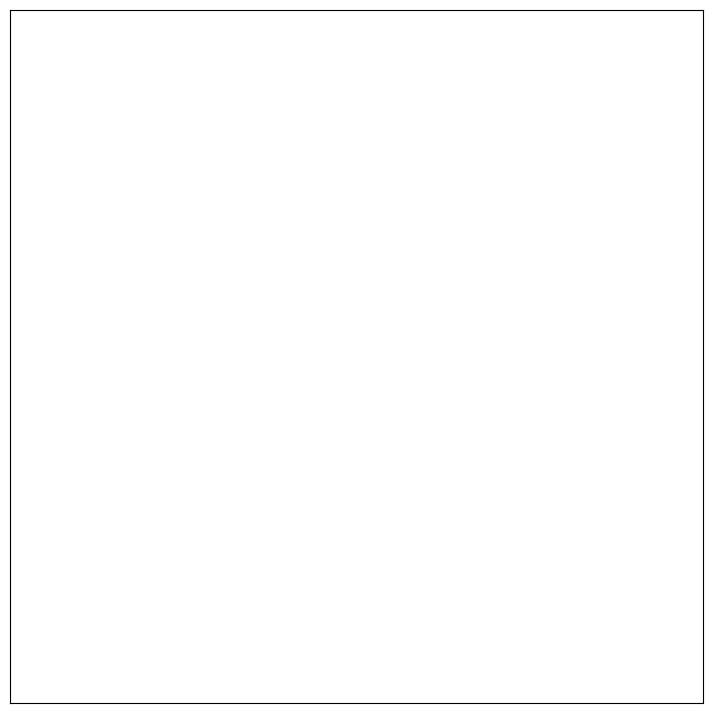

In [4]:
# simulation settings
delta_t = 0.02 # [sec]
sim_steps = 200 # [steps]
print(f"[INFO] delta_t : {delta_t:.2f}[s] , sim_steps : {sim_steps}[steps], total_sim_time : {delta_t*sim_steps:.2f}[s]")

# initialize a cartpole as a control target
cartpole = CartPole(
    mass_of_cart = 1.0,
    mass_of_pole = 0.01,
    length_of_pole = 2.0, 
    max_force_abs = 100.0,
)
cartpole.reset(
    init_state = np.array([0.0, np.pi, 0.0, 0.0]), # [x[m], theta[rad], x_dot[m/s], theta_dot[rad/s]]
)

# initialize a mppi controller for the cartpole
mppi = MPPIControllerForCartPole(
    delta_t = delta_t,
    mass_of_cart = 1.0,
    mass_of_pole = 0.01,
    length_of_pole = 2.0,
    max_force_abs = 100.0,
    horizon_step_T = 100,
    number_of_samples_K = 1000,
    param_exploration = 0.0,
    param_lambda = 50.0,
    param_alpha = 1.0,
    sigma = 10.0,
    stage_cost_weight    = np.array([5.0, 10.0, 0.1, 0.1]), # weight for [x, theta, x_dot, theta_dot]
    terminal_cost_weight = np.array([5.0, 10.0, 0.1, 0.1]), # weight for [x, theta, x_dot, theta_dot]
)

# simulation loop
for i in range(sim_steps):

    # get current state of cartpole
    current_state = cartpole.get_state()

    # calculate input force with MPPI
    input_force, input_force_sequence = mppi.calc_control_input(
        observed_x = current_state
    )

    # print current state and input force
    print(f"Time: {i*delta_t:>2.2f}[s], x={current_state[0]:>+3.3f}[m], theta={current_state[1]:>+3.3f}[rad], input force={input_force:>+6.2f}[N]")

    # update states of cartpole
    cartpole.update(u=[input_force], delta_t=delta_t)

# show animation
cartpole.show_animation(interval_ms=int(delta_t * 1000))
# save animation
cartpole.save_animation("mppi_cartpole.mp4", interval=int(delta_t * 1000), movie_writer="ffmpeg") # ffmpeg is required to write mp4 file